# "Experiments with SoA techniques"
> "This notebook contains a series of experimentations using different approaches in the training process of a Convolutional Neural Network using a subsection of the [MAMMOSET](https://bitbucket.org/gbdi/mammoset/src/master/) dataset"

- toc: true
- branch: master
- badges: true
- author: João Marcelo Tozato
- categories: [fastpages, jupyter, fastai, DDSM, mass]

### Imports

In [26]:
from fastai2.vision.all import *
from utils import *
path = Path('./DDSM_NOBARS/MASS/'); path.ls()

(#2) [Path('DDSM_NOBARS/MASS/benigna'),Path('DDSM_NOBARS/MASS/maligna')]

### DataBlock/DataLoaders

In [2]:
dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_items=get_image_files,
                   get_y=parent_label,
                   splitter=RandomSplitter(seed=42),
                   item_tfms=Resize(460),
                   batch_tfms=aug_transforms(size=224, min_scale=0.75))
#dblock.summary(path)
dls = dblock.dataloaders(path, bs=64)

### Baseline run

In [3]:
model = resnet34()
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, error_rate]).to_fp16()
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,7.298484,49.292488,0.000000,1.000000,00:06
1,3.581588,1.451827,0.404858,0.595142,00:06
2,2.321033,0.743234,0.461538,0.538462,00:06
3,1.713093,0.695602,0.502024,0.497976,00:06
4,1.362898,0.681767,0.595142,0.404858,00:06


/home/jmtzt/fastbook/lib/python3.8/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


### Normalization

Testing if the data is normalized i.e. has a mean of 0 and a std of 1.

In [4]:
x,y = dls.one_batch()
x.shape,y.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [5]:
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([0.5666, 0.5666, 0.5666], device='cuda:0'),
 TensorImage([0.1686, 0.1686, 0.1686], device='cuda:0'))

The mean and standart deviation are not close to the desired values, therefore we need to normalize them by adding to the DataBlock the `Normalize` transform that uses the ImageNet mean and std.

In [6]:
def get_dls(bs, size):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label,
                   splitter=RandomSplitter(seed=42),
                   item_tfms=Resize(460),
                   batch_tfms=[*aug_transforms(size=size, min_scale=0.75),
                               Normalize.from_stats(*imagenet_stats)])
    return dblock.dataloaders(path, bs=bs)

In [7]:
dls = get_dls(64, 224)
x,y = dls.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([0.3459, 0.4831, 0.7032], device='cuda:0'),
 TensorImage([0.7476, 0.7643, 0.7609], device='cuda:0'))

Checking if it affects our model 

In [8]:
model = resnet34()
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, error_rate]).to_fp16()
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,6.589247,nan,0.534413,0.465587,00:06
1,3.267678,1.586851,0.615385,0.384615,00:06
2,2.144929,1.013776,0.599190,0.400810,00:06
3,1.608513,0.705930,0.437247,0.562753,00:06
4,1.298861,0.669487,0.619433,0.380567,00:06


We can see some improvement in our acccuracy, but not a whole lot, because we are training this model from scratch. If we were to train this model based on a transfer learning approach, we would have to pay even more attention to that, in order to match the statistics used for normalization of the pre-trained model.

### Progressive Resizing

This approach is basically gradually using larger and larger images as you train your model

In [13]:
dls = get_dls(128, 128)
learn = Learner(dls, resnet34(), loss_func=CrossEntropyLossFlat(), 
                metrics=[accuracy, error_rate]).to_fp16()
learn.fit_one_cycle(4, 3e-3)

/home/jmtzt/fastbook/lib/python3.8/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,7.789251,7.220915,0.000000,1.000000,00:05
1,6.119124,nan,0.570850,0.429150,00:05
2,4.074199,nan,0.562753,0.437247,00:05
3,3.038997,5.341589,0.518219,0.481781,00:06


We increase the image resolution and decrease the batch size and proceed to fine-tune the model:

In [14]:
learn.dls = get_dls(64, 224)
learn.fine_tune(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.699829,0.706627,0.510121,0.489879,00:06


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.677542,0.713452,0.599190,0.400810,00:06
1,0.681381,0.686060,0.635628,0.364372,00:06
2,0.682831,0.699931,0.510121,0.489879,00:06
3,0.685403,0.668482,0.619433,0.380567,00:06
4,0.682514,0.671242,0.663968,0.336032,00:06


As we can see, the accuracy improved when using this technique.

### Test Time Augmentation (TTA)

Up until now we have been using random cropping as data augmentation, which may lead to some problems such as some critical features being cropped out of the image. One technique that might help mitigate this problem is select a number of areas to crop from the original rectangular image and then pass each of them through the model and take the average of the predictions, that is just applying a form of augmentation in the validation dataset as well.

In [17]:
preds,targs = learn.tta()
accuracy(preds, targs).item()

/home/jmtzt/fastbook/lib/python3.8/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


0.659919023513794

### Mixup Technique

mixup: Beyond Empirical Risk Minimization: https://arxiv.org/abs/1710.09412

Mixup works as follows, for each image:

1. Select another image from your dataset at random.
1. Pick a weight at random.
1. Take a weighted average (using the weight from step 2) of the selected image with your image; this will be your independent variable.
1. Take a weighted average (with the same weight) of this image's labels with your image's labels; this will be your dependent variable.

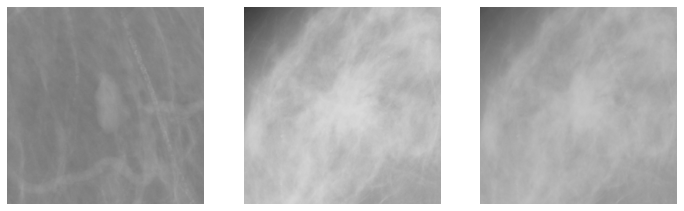

In [29]:
ben = PILImage.create(get_image_files_sorted(path/'benigna')[0])
mal = PILImage.create(get_image_files_sorted(path/'maligna')[0])
ben = ben.resize((256,256))
mal = mal.resize((256,256))
tben = tensor(ben).float() / 255.
tmal = tensor(mal).float() / 255.

_,axs = plt.subplots(1, 3, figsize=(12,4))
show_image(tben, ax=axs[0]);
show_image(tmal, ax=axs[1]);
show_image((0.3*tben + 0.7*tmal), ax=axs[2]);

The third image is 30% the first one and 70% the second one, so the model must predict 30% benign and 70% malign. So the one-hot-encoded representations of the predicitons are (in this dataset which we have 2 classes):
```
[1,0] and [0, 1]
```
But we are aiming for this type of prediction:

```
[0.3, 0.7]
```

In [21]:
model = resnet34()
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), 
                metrics=[accuracy, error_rate], cbs=MixUp)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,4.664900,208.644165,0.591093,0.408907,00:07
1,2.637848,194.706757,0.591093,0.408907,00:06
2,1.903277,1.384996,0.526316,0.473684,00:06
3,1.535061,0.859590,0.534413,0.465587,00:06
4,1.315490,0.679021,0.615385,0.384615,00:06


/home/jmtzt/fastbook/lib/python3.8/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


Training in this way, without explicitly telling the model that the labels must be biggen than 0 but smaller than 1, makes our activations more extreme as we train for more epochs. That is the reason why we will use label smoothing to deal with this.

### Label Smoothing

Rethinking the Inception Architecture for Computer Vision: https://arxiv.org/abs/1512.00567

Instead of using regular one-hot-encoded vectors for the targets, we should use targets in the following format:
```
[0.1, 0.9]
```
This helps we do not encourage the model to predict something overconfidently.

In [32]:
model = resnet34()
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(), 
                metrics=[accuracy, error_rate], cbs=MixUp)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,4.738817,4001.799072,0.000000,1.000000,00:07
1,3.226263,1226.570801,0.591093,0.408907,00:07
2,2.642515,60.685635,0.518219,0.481781,00:06
3,2.353480,4.580351,0.554656,0.445344,00:06
4,2.170954,1.858582,0.530364,0.469636,00:07


/home/jmtzt/fastbook/lib/python3.8/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


Normally we see improvements both from the MixUp and the Label Smoothing technique when we train the model for more epochs.